# Water Risk Classification: Data Wrangling

## Setup

In [19]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import plot
import requests, zipfile, io, os, tarfile
from matplotlib import pyplot

%matplotlib inline

## Download Data
**ONLY RUN IF YOU DON'T HAVE THE DATA FOLDER YET. IT WILL TAKE A LONG TIME.**

Download and unzip all the datasets. 

WRI Aqueduct. View [metadata](https://github.com/wri/aqueduct30_data_download/blob/master/metadata.md).

In [ ]:
# create data folder
os.mkdir('./data')

In [7]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_aq = 'https://wri-projects.s3.amazonaws.com/Aqueduct30/finalData/Y2019M07D12_Aqueduct30_V01.zip'

r = requests.get(url_aq) # download zipped directory
z = zipfile.ZipFile(io.BytesIO(r.content)) # create zipfile object
z.extractall(path='data') # unzip into data subdirectory

European Commission's Global Human Settlements Layer

In [5]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_ghs = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_SMOD_POP_GLOBE_R2019A/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K/V1-0/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V1_0.zip'

r = requests.get(url_ghs) # download zipped directory
z = zipfile.ZipFile(io.BytesIO(r.content)) # create zipfile object
z.extractall(path='data/ghs') # unzip into data subdirectory

NASA SEDAC Poverty Data. Exact datasets TBD.

In [3]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_inf_mort = 'https://sedac.ciesin.columbia.edu/downloads/data/povmap/povmap-global-subnational-infant-mortality-rates-v2/povmap-global-subnational-infant-mortality-rates-v2-geotiff.zip'

r = requests.get(url_sedac) # download zipped directory
z = zipfile.ZipFile(io.BytesIO(r.content)) # create zipfile object
z.extractall(path='data/sedac') # unzip into data subdirectory

NameError: name 'url_sedac' is not defined

Version 4 DMSP-OLS Nighttime Lights Time Series

In [20]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_light = 'https://ngdc.noaa.gov/eog/data/web_data/v4avg_lights_x_pct/F182013.v4c.avg_lights_x_pct.tgz'

r = requests.get(url_light) # download zipped directory
z = tarfile.open(r.content, mode='r:gz') # create zipfile object
z.extractall(path='data/light') # unzip into data subdirectory

TypeError: expected str, bytes or os.PathLike object, not _io.BytesIO

## Load Data

In [17]:
path_aq = './data/Y2019M07D12_Aqueduct30_V01/baseline/annual/y2019m07d11_aqueduct30_annual_v01.gpkg'

aq = gpd.read_file(path_aq, layer='y2019m07d11_aqueduct30_annual_v01')

aq.head()

,string_id,aq30_id,pfaf_id,gid_1,aqid,gid_0,name_0,name_1,area_km2,bws_raw,...,w_awr_tex_rrr_score,w_awr_tex_rrr_cat,w_awr_tex_rrr_label,w_awr_tex_rrr_weight_fraction,w_awr_tex_tot_raw,w_awr_tex_tot_score,w_awr_tex_tot_cat,w_awr_tex_tot_label,w_awr_tex_tot_weight_fraction,geometry
0,111011-EGY.11_1-3365,0,111011,EGY.11_1,3365,EGY,Egypt,Al Qahirah,4.223754,2.318042,...,2.165272,2.0,Medium - High (2-3),0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((31.90590570688292 29.85788703615783...
1,111011-EGY.15_1-3365,1,111011,EGY.15_1,3365,EGY,Egypt,As Suways,1846.012343,2.318042,...,2.165272,2.0,Medium - High (2-3),0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((31.90256665452753 29.82957728496378...
2,111011-EGY.15_1-None,2,111011,EGY.15_1,-9999,EGY,Egypt,As Suways,30.526067,2.318042,...,2.165272,2.0,Medium - High (2-3),0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((32.36609158210641 29.63378296420298...
3,111011-None-3365,3,111011,-9999,3365,None,None,None,0.742712,2.318042,...,1.133763,1.0,Low - Medium (1-2),0.163265,2.477321,3.649648,3.0,High (3-4),0.551020,(POLYGON ((32.46194054146073 29.89250514754305...
4,111011-None-None,4,111011,-9999,-9999,None,None,None,13.430995,2.318042,...,1.133763,1.0,Low - Medium (1-2),0.163265,2.477321,3.649648,3.0,High (3-4),0.551020,(POLYGON ((32.46439791820441 29.88855938783929...


In [9]:
path_ghs = './data/ghs/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V1_0.tif'

ghs = rasterio.open(path_ghs)
print(ghs.width, ghs.height)
print(ghs.crs)
print(ghs.transform)
print(ghs.count)
print(ghs.indexes)

36082 18000
PROJCS["World_Mollweide",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Mollweide"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]
| 1000.00, 0.00,-18041000.00|
| 0.00,-1000.00, 9000000.00|
| 0.00, 0.00, 1.00|
1
(1,)


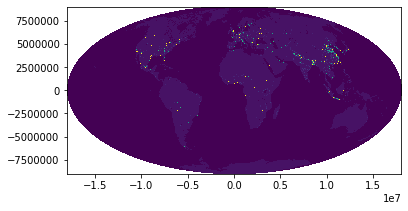

In [14]:
plot.show(ghs)

In [ ]:
path_inf_mort = './data/sedac'

inf_mort = 

In [ ]:
path_light = './data/light/'

light = 

## Join Data

## Engineer Features

## Save GeoJSON for Modeling